# Homework 4 - 2305

*   Tommaso Bertola 2086990
*    Giacomo Di Prima 2086992
*    Giuseppe Viterbo 2086516
*    Marzo Zenari 2097012



In [67]:
# XGBoost 
import numpy as np
import matplotlib.pyplot as plt

#XGB
import xgboost
from xgboost import XGBRegressor
from xgboost import XGBClassifier
import graphviz
from xgboost import plot_importance, to_graphviz, plot_tree
print("XGBoost version:",xgboost.__version__)

#NN
import tensorflow as tf
import keras, sklearn
from keras.models import Sequential
from keras.layers import Dense, Dropout
import tensorflow.random as tf_r
from tensorflow.keras.optimizers.legacy import Adam

tf_r.set_seed(123)
plt.rcParams['font.size'] = 15

XGBoost version: 1.7.5


## Generation of the data and plot

In [97]:
def gen_data(CASE, N, perc_train, S=2):
    np.random.seed(123)
    N_train = int(N*perc_train)
    N_test  = N - N_train
    x = S*(2*np.random.rand(N,2)-1)
    y = np.zeros(N) # float
    for n in range(N):
        if CASE==0:
            if x[n,1]<-0.6 and x[n,0]>-0.2: y[n]=1
            if x[n,1]>0.4 and x[n,0]<-0.8: y[n]=1
            if x[n,1]>1.0 and x[n,0]>0.8: y[n]=1
        elif CASE==1:
            if x[n,1]<0 and x[n,0]>0.5: y[n]=1
            if x[n,1]>0 and np.sqrt((x[n,0]+0.3)**2+x[n,1]**2)<1.5: y[n]=1
#         elif CASE==2: 
#               y[n] = -100.*x[n,0]
#               y[n] += 100.*np.cos(3.14*x[n,1])
#         elif CASE==3: 
#               y[n] = -100.*x[n,0]
#               y[n] += -100.*x[n,1] 
                
    x_train,y_train = x[:N_train],y[:N_train]
    x_test,y_test = x[N_train:],y[N_train:]
    print('N:', N, 'N_train:', N_train, 'CASE:', CASE)
    return x_train, y_train, x_test, y_test

def plot_scatter(x, y, c_map='plasma', s=4):
    plt.scatter(x[:,0], x[:,1], c=y, cmap=c_map, s=s)

N: 10000 N_train: 8500 CASE: 1


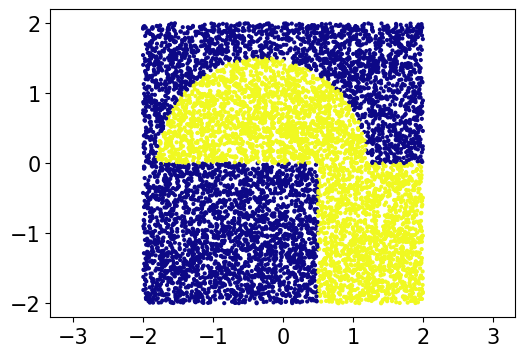

In [102]:
CASE=1
S=2
N=10000
perc_train=0.85
x_train, y_train, x_test, y_test = gen_data(CASE=CASE, N=N, perc_train=perc_train, S=S)
plt.figure(figsize=(6,4))
plot_scatter(x_train, y_train)
if CASE == 2 or CASE == 3: plt.colorbar()
plt.axis('equal')
plt.show()

# 1) XGB vs NN

## Classifier: XGB

In [81]:
def classify(clf=XGBClassifier(),show=False):
    clf.fit(x_train,y_train)

    print("errors: {:.2f}%".format(100*(1-clf.score(x_test, y_test))))
        
    dx = 0.02
    x_seq=np.arange(-S,S+dx,dx)
    nx = len(x_seq)
    x_plot=np.zeros((nx*nx,2))
    q=0
    for i in range(nx):
        for j in range(nx):
            x_plot[q,:] = [x_seq[i],x_seq[j]]
            q+=1
    y_plot= clf.predict(x_plot)

    if show:    
        plt.figure(figsize=(6,6))
        plt.title(str(clf))

        plot_scatter(x_plot,y_plot)
        plot_scatter(x_train,y_train,s=7)
        plt.show()
    
        dump_list = clf.get_booster().get_dump()
        num_trees = len(dump_list)
        print("num_trees=",num_trees)
        
        fig, AX = plt.subplots(3,1,figsize=(30, 30))
        for i in range(min(3,num_trees)):
            ax=AX[i]
            plot_tree(clf, num_trees=i, ax=ax)
        fig.savefig("DATA/tree-classif.png", dpi=300, pad_inches=0.02)   
        plt.show()

### simple case

errors: 0.70%


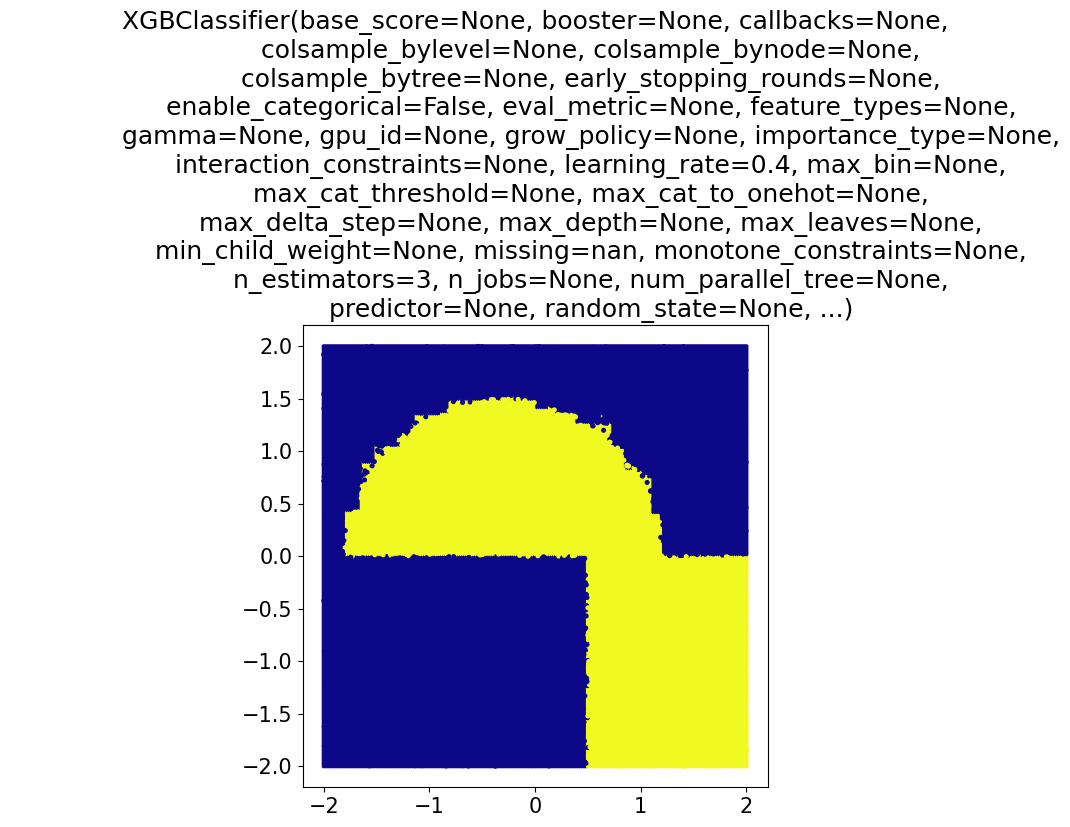

num_trees= 3


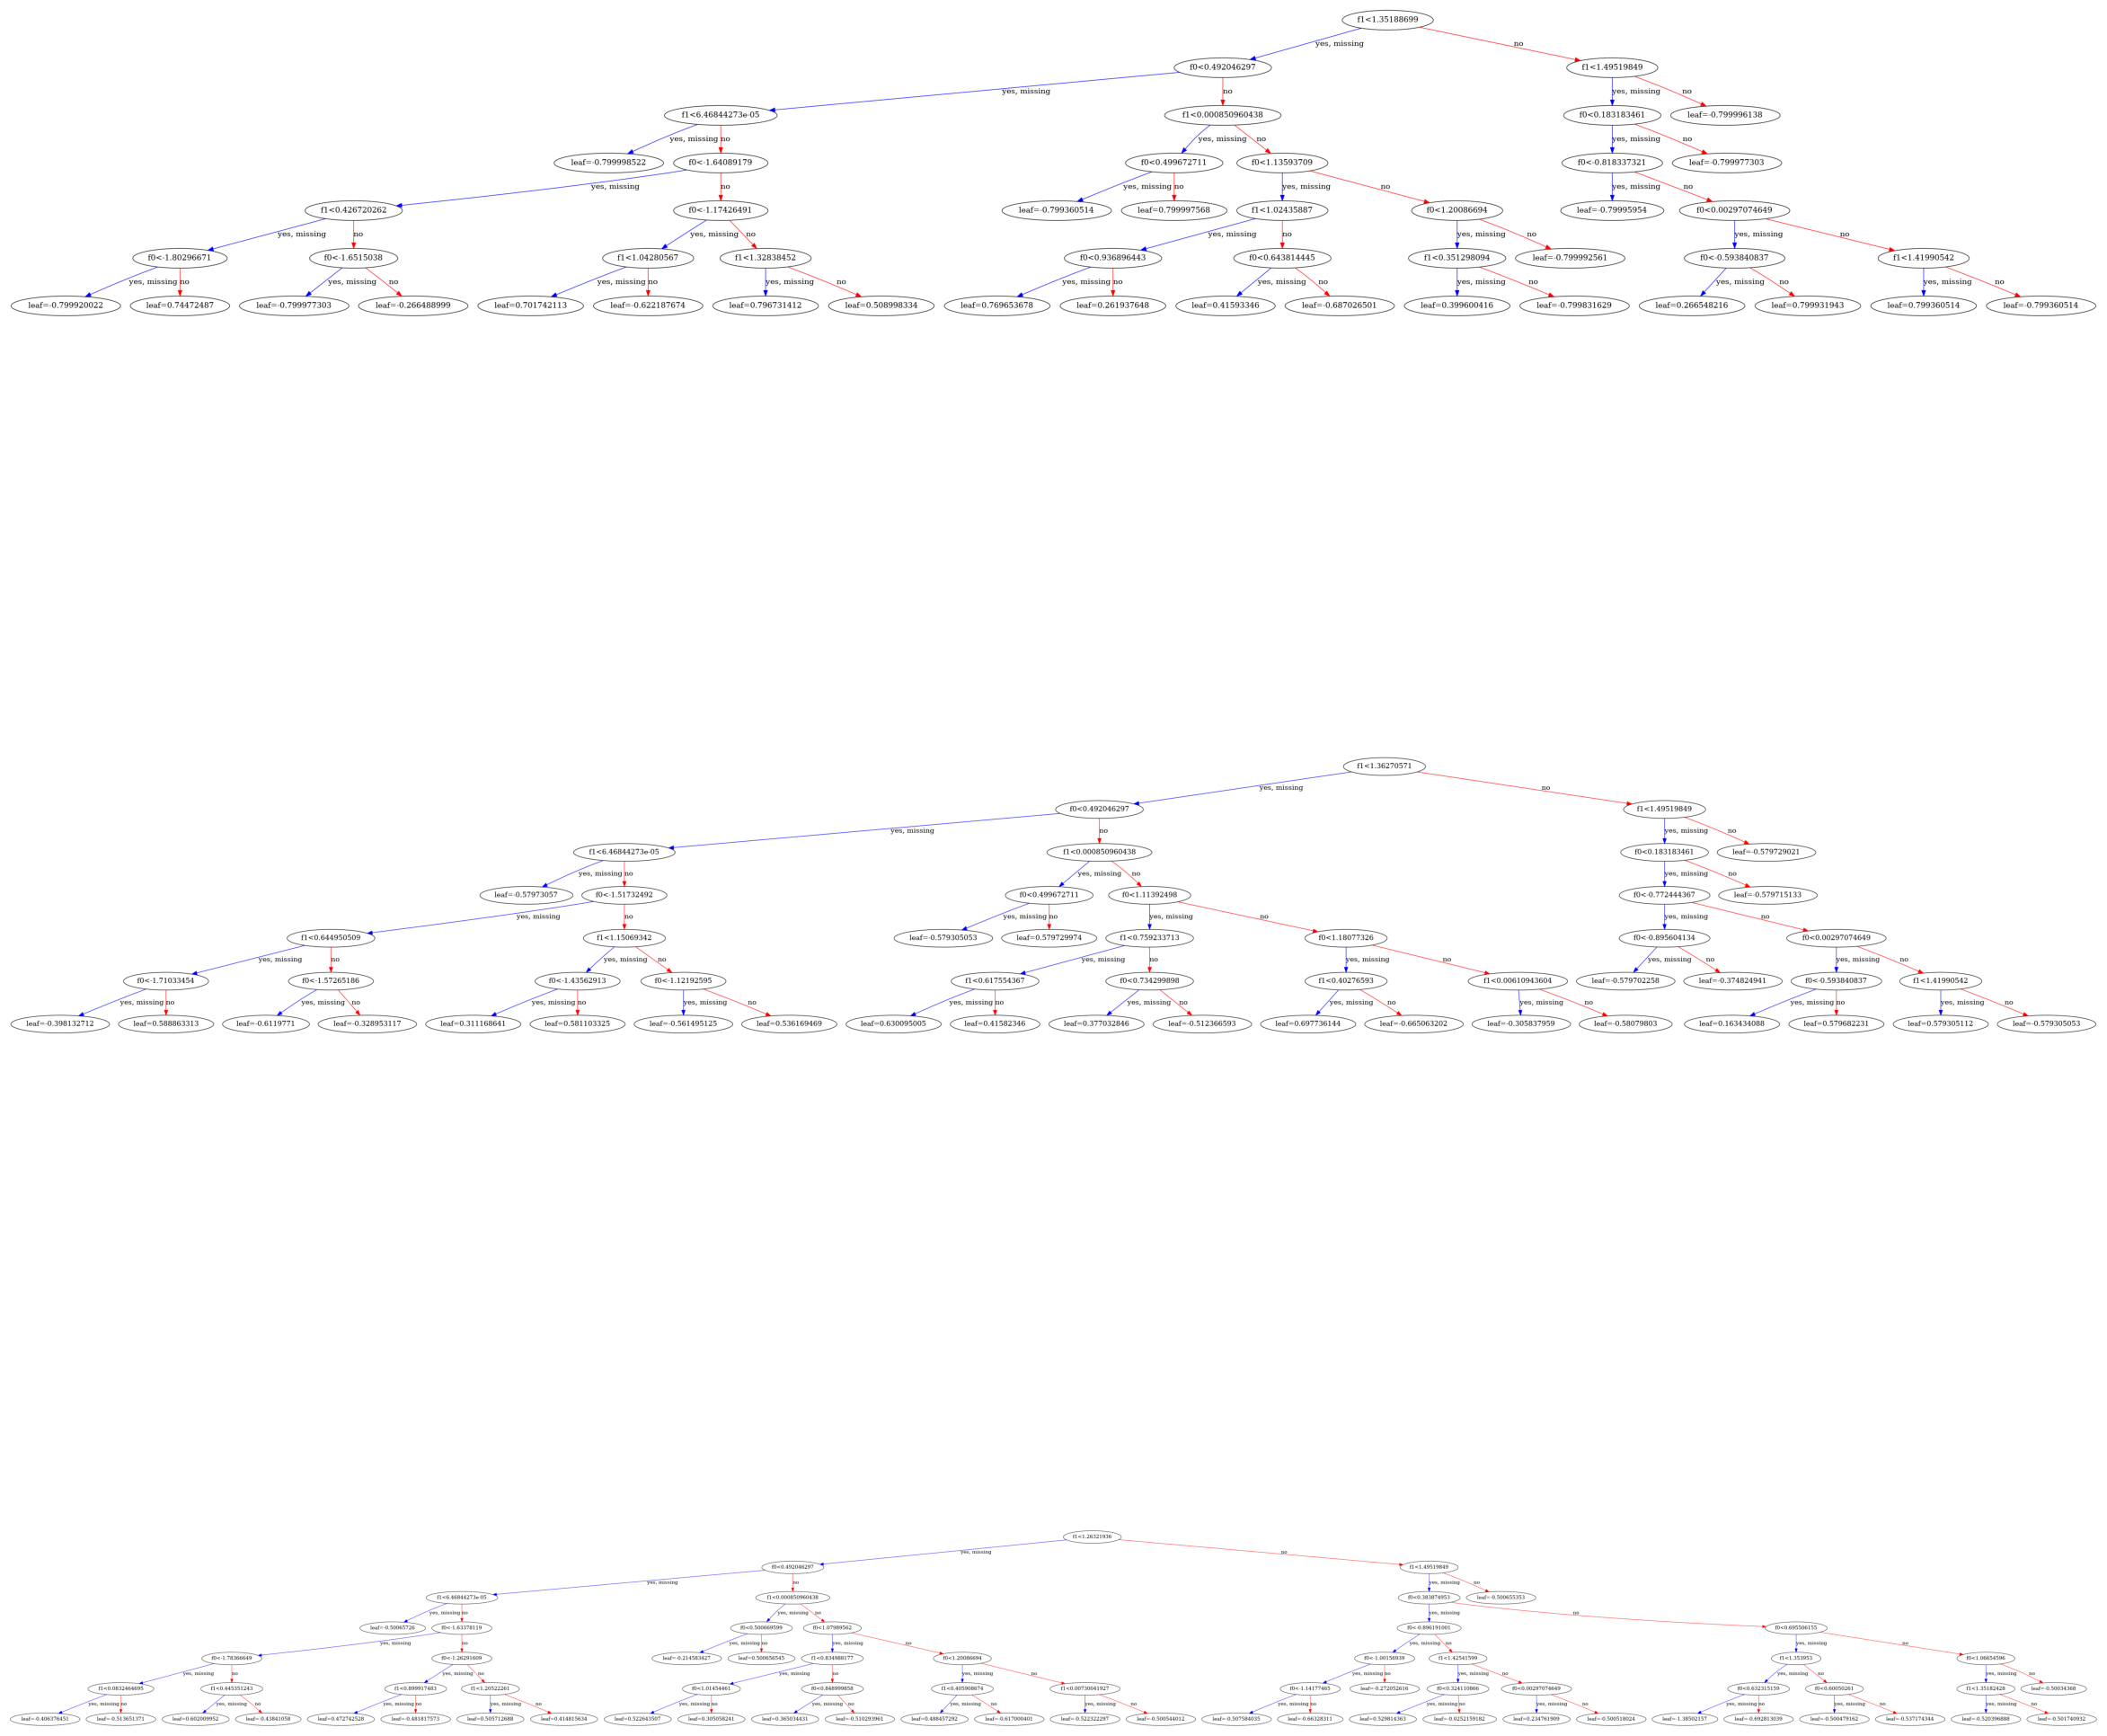

In [82]:
classify(XGBClassifier(seed=1,
                       objective='binary:logistic',
                       learning_rate=0.4,
                       reg_lambda=0.001, n_estimators=3), show=True)

## Classifier: NN

Rescaling to improve NN

In [104]:
def Rescale(x, S=S):
    return x/S
x_train = Rescale(x_train, S)
y_train = Rescale(y_train, S)
x_test = Rescale(x_test, S)
y_test = Rescale(y_test, S)

In [69]:
L = len(x_train[0])

### NN

In [111]:
def create_DNN(act_func, neurons): 
    model = Sequential() #empty template of the neural network
    model.add(Dense(L,input_shape=(L,),activation=act_func)) #add a layer dense (all connection) with a ReLu 2 neuron for 2 x_i
    model.add(Dense(units=neurons,activation=act_func))
    model.add(Dense(units=neurons,activation=act_func))
    model.add(Dense(units=neurons,activation=act_func))
    model.add(Dropout(0.01)) #it is applied to the last layer, need to be reader in keras documentation 
    model.add(Dense(1,activation='tanh'))
        
    return model 

In [112]:
def compile_model(optimizer='adam', act_func='relu', neurons=10):
    model = create_DNN(act_func, neurons)
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])    
    return model

In [113]:
nepochs=100

model = compile_model(optimizer='Adam',
                      act_func='ReLU',
                      neurons=30)

history = model.fit(x_train, y_train,
                    epochs = nepochs,
                    batch_size = 1000,
                    validation_data=(x_test,y_test),
                    verbose=1)

Epoch 1/100


2023-04-04 13:52:20.843178: W tensorflow/compiler/xla/service/gpu/llvm_gpu_backend/gpu_backend_lib.cc:326] libdevice is required by this HLO module but was not found at ./libdevice.10.bc
2023-04-04 13:52:20.843644: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:446 : INTERNAL: libdevice not found at ./libdevice.10.bc
2023-04-04 13:52:20.863824: W tensorflow/compiler/xla/service/gpu/llvm_gpu_backend/gpu_backend_lib.cc:326] libdevice is required by this HLO module but was not found at ./libdevice.10.bc
2023-04-04 13:52:20.864170: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:446 : INTERNAL: libdevice not found at ./libdevice.10.bc
2023-04-04 13:52:20.892638: W tensorflow/compiler/xla/service/gpu/llvm_gpu_backend/gpu_backend_lib.cc:326] libdevice is required by this HLO module but was not found at ./libdevice.10.bc
2023-04-04 13:52:20.893068: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:4

InternalError: Graph execution error:

Detected at node 'StatefulPartitionedCall_8' defined at (most recent call last):
    File "/home/vepe/miniconda3/envs/new_tf_gpu/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/vepe/miniconda3/envs/new_tf_gpu/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/vepe/miniconda3/envs/new_tf_gpu/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/vepe/miniconda3/envs/new_tf_gpu/lib/python3.9/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/home/vepe/miniconda3/envs/new_tf_gpu/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 725, in start
      self.io_loop.start()
    File "/home/vepe/miniconda3/envs/new_tf_gpu/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/home/vepe/miniconda3/envs/new_tf_gpu/lib/python3.9/asyncio/base_events.py", line 601, in run_forever
      self._run_once()
    File "/home/vepe/miniconda3/envs/new_tf_gpu/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once
      handle._run()
    File "/home/vepe/miniconda3/envs/new_tf_gpu/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/vepe/miniconda3/envs/new_tf_gpu/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "/home/vepe/miniconda3/envs/new_tf_gpu/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "/home/vepe/miniconda3/envs/new_tf_gpu/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 409, in dispatch_shell
      await result
    File "/home/vepe/miniconda3/envs/new_tf_gpu/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/home/vepe/miniconda3/envs/new_tf_gpu/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/home/vepe/miniconda3/envs/new_tf_gpu/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/vepe/miniconda3/envs/new_tf_gpu/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2961, in run_cell
      result = self._run_cell(
    File "/home/vepe/miniconda3/envs/new_tf_gpu/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3016, in _run_cell
      result = runner(coro)
    File "/home/vepe/miniconda3/envs/new_tf_gpu/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/vepe/miniconda3/envs/new_tf_gpu/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3221, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/vepe/miniconda3/envs/new_tf_gpu/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3400, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/vepe/miniconda3/envs/new_tf_gpu/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3460, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_14086/2705693725.py", line 7, in <module>
      history = model.fit(x_train, y_train,
    File "/home/vepe/miniconda3/envs/new_tf_gpu/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/vepe/miniconda3/envs/new_tf_gpu/lib/python3.9/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/vepe/miniconda3/envs/new_tf_gpu/lib/python3.9/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/home/vepe/miniconda3/envs/new_tf_gpu/lib/python3.9/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/vepe/miniconda3/envs/new_tf_gpu/lib/python3.9/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/home/vepe/miniconda3/envs/new_tf_gpu/lib/python3.9/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/home/vepe/miniconda3/envs/new_tf_gpu/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
      self.apply_gradients(grads_and_vars)
    File "/home/vepe/miniconda3/envs/new_tf_gpu/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/home/vepe/miniconda3/envs/new_tf_gpu/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/home/vepe/miniconda3/envs/new_tf_gpu/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/home/vepe/miniconda3/envs/new_tf_gpu/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/home/vepe/miniconda3/envs/new_tf_gpu/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_8'
libdevice not found at ./libdevice.10.bc
	 [[{{node StatefulPartitionedCall_8}}]] [Op:__inference_train_function_16965]

# 2) XGB tuning

In [83]:
lam=[100,30,20,10,5,1,0.5,0.1]
for l in lam:
    print("lambda=",l)
    classify(XGBClassifier(seed=1,
                       objective='binary:logistic',
                       learning_rate=0.4,
                       reg_lambda=l, n_estimators=3), show=False)

lambda= 100
errors: 3.10%
lambda= 30
errors: 1.63%
lambda= 20
errors: 1.30%
lambda= 10
errors: 0.83%
lambda= 5
errors: 0.93%
lambda= 1
errors: 0.60%
lambda= 0.5
errors: 0.67%
lambda= 0.1
errors: 0.60%


In [88]:
gam=[0.,1.,2.,4.,10.,20.,40.,100.,200.]
for g in gam:
    print("gamma=",g)
    classify(XGBClassifier(seed=1,
                       objective='binary:logistic',
                       learning_rate=0.4,
                       reg_lambda=1, gamma=g, n_estimators=3), show=False)

gamma= 0.0
errors: 0.60%
gamma= 1.0
errors: 0.60%
gamma= 2.0
errors: 0.80%
gamma= 4.0
errors: 0.80%
gamma= 10.0
errors: 0.63%
gamma= 20.0
errors: 0.67%
gamma= 40.0
errors: 1.43%
gamma= 100.0
errors: 2.40%
gamma= 200.0
errors: 3.47%


In [92]:
n_estimator=[3,4,5,6,7,8]
for n in n_estimator:
    print("n_estimator=",n)
    classify(XGBClassifier(seed=1,
                       objective='binary:logistic',
                       learning_rate=0.4,
                       reg_lambda=1, gamma=1, n_estimators=n), show=False)

n_estimator= 3
errors: 0.60%
n_estimator= 4
errors: 0.50%
n_estimator= 5
errors: 0.53%
n_estimator= 6
errors: 0.43%
n_estimator= 7
errors: 0.60%
n_estimator= 8
errors: 0.60%
